In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from scipy import stats
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, SVD, NMF, accuracy
from collections import defaultdict

# Data Parsing

In [2]:
# initialize data
item_threshold = 1 # used to filter out user/artist pairs that have been 
                   #listened to less than the threshold number of times
popular_artist_fraction = 0.2 # top cutoff for what we consider popular artists, in this case the top 20%

user_events_file = '../data/user_events.txt'
low_user_file = '../data/low_main_users.txt'
medium_user_file = '../data/medium_main_users.txt'
high_user_file = '../data/high_main_users.txt'

In [3]:
#read in user events file
cols = ['user', 'artist', 'album', 'track', 'timestamp']
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of user events: ' + str(len(df_events)))
df_events.head() # check it is all read in properly

No. of user events: 28718087


,user,artist,album,track,timestamp
0,31435741,2,4,4,1385212958
1,31435741,2,4,4,1385212642
2,31435741,2,4,4,1385212325
3,31435741,2,4,4,1385209508
4,31435741,2,4,4,1385209191


## User-Artist Matrix

In [4]:
# create unique user-artist matrix
df_events = df_events.groupby(['user', 'artist']).size().reset_index(name='count')
print('No. user-artist pairs: ' + str(len(df_events)))
# each row contains a unique user-artist pair, along with how many times the
# user has listened to the artist
df_events.head()

No. user-artist pairs: 1755361


,user,artist,count
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1


In [5]:
# filters out artist/user pairs who havent been listened two more than
# item_threshold amount of times to reduce
# kept mostly to 1 so we dont filter out any data currently
df_events = df_events[df_events['count'] >= item_threshold] 

# With 1, we see no difference between user-artist pairs here
print('No. filtered user-artist pairs: ' + str(len(df_events))) 

# here, we see the number of unique artists in our matrix
print('No. unique artists: ' + str(len(df_events['artist'].unique())))

No. filtered user-artist pairs: 1755361
No. unique artists: 352805


#### How many artists have users listened to?

In [6]:
# get matrix where each row is a user-id and how many artists they've 
#listened to
user_dist = df_events['user'].value_counts() 

# counts how many unique users there are. prints out user id & a count of how 
# many rows they're included in, which effectively shows how many artists 
# they listen to
num_users = len(user_dist)
print('Mean artists of all users: ' + str(user_dist.mean()))
print('Min artists of all users: ' + str(user_dist.min()))
print('Max artists of all users: ' + str(user_dist.max()))

user_dist.head()



Mean artists of all users: 585.1203333333333
Min artists of all users: 18
Max artists of all users: 4011


41888522    4011
4393555     3700
40029632    3678
26874346    3544
29736410    3529
Name: user, dtype: int64

#### How many users listen to an artist?

In [7]:
# get artist distribution
# same as previous but with artists, shows artist-id and how many times they
# were listened to buy unique users
artist_dist = df_events['artist'].value_counts()
num_artists = len(artist_dist)
print('No. artists: ' + str(num_artists))
df_events['artist'].value_counts().head

No. artists: 352805


<bound method NDFrame.head of 135        1389
1602       1359
46         1325
320        1297
27         1290
           ... 
3124286       1
1029181       1
1023032       1
1008679       1
3087545       1
Name: artist, Length: 352805, dtype: int64>

### Graphs From Data Parsing

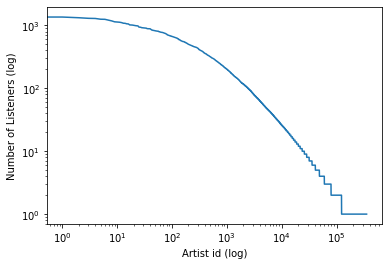

In [8]:
#plots x,y pairs of each row
# x is the artist id, y is the number of listeners 
# log both axes for feature scaling purposes
plot.plot(artist_dist.values)
plot.xlabel('Artist id (log)')
plot.ylabel('Number of Listeners (log)')
plot.xscale("log")
plot.yscale("log")

In [9]:
# get number of  popular artists
num_top_artists = int(popular_artist_fraction * num_artists)

# getting the top top_fraction (0.2) percent of artists, so finding how many
# artists make up 20% of total artists, and then only using the artists those
#number of the most popular aritsts
top_artist_dist = artist_dist[:num_top_artists]
print('No. top artists: ' + str(len(top_artist_dist)))

No. top artists: 70561


In [10]:
# read in users
# user file is just user_id and their mainstreaminess value 
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [11]:
low_users.head()

,M_global_R_APC
user_id,
20146143,-0.260074
32463394,-0.253610
47706954,-0.236572
19772905,-0.215595
21128139,-0.199496


## Calculating GAP of User Profiles

In [12]:
# get popularity metrics
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_artist_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap_p = 0
medium_profile_size = 0
medium_gap_p = 0
high_profile_size = 0
high_gap_p = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_artists = len(set(df['artist'])) # profile size //number of artists in users profile
    # top items in profile //top percent of pop artists in users profile
    no_user_pop_artists = len(set(df['artist']) & set(top_artist_dist.index)) 
    pop_count.append(no_user_pop_artists) # adds users # of pop artists to a list 
    user_hist.append(no_user_artists) #sizes of users listening histories
    pop_fraq.append(no_user_pop_artists / no_user_artists) #fraction of pop items in profile / total items
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_artist_fraq = sum(artist_dist[df['artist']] / no_users) / no_user_artists
    pop_artist_fraq.append(user_pop_artist_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_artists
        low_gap_p += user_pop_artist_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_artists
        medium_gap_p += user_pop_artist_fraq
        med_count += 1
    else:
        high_profile_size += no_user_artists
        high_gap_p += user_pop_artist_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap_p /= len(low_users) # average popularity of items/artists in low/med/high groups (gap = group average popularity)
medium_gap_p /= len(medium_users)
high_gap_p /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))


Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


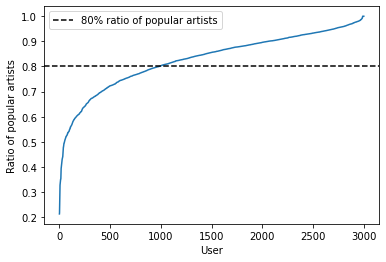

In [59]:
# Plot of how many popular artists are in each user profile
plot.figure()
plot.plot(sorted(pop_fraq))
plot.xlabel('User')
plot.ylabel('Ratio of popular artists')
plot.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular artists')
plot.legend()

Text(0, 0.5, 'Number of popular artists')

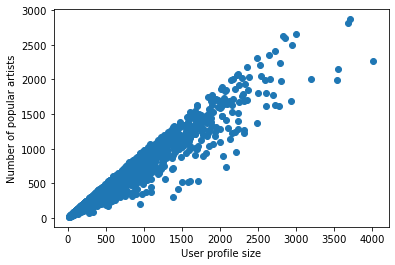

In [14]:
# Plot of profile size vs the number of popular artists in it
plot.figure()
plot.plot(user_hist, pop_count, 'o')
plot.xlabel('User profile size', )
plot.ylabel('Number of popular artists')

Text(0, 0.5, 'Average popularity of artists')

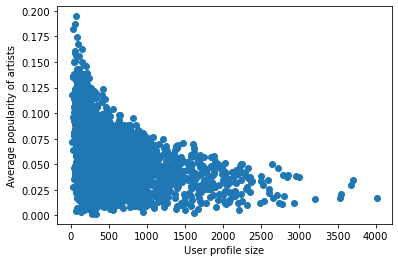

In [15]:
# plot of profile size vs the average popularity of artists in it
plot.figure()
plot.plot(user_hist, pop_artist_fraq, 'o')
plot.xlabel('User profile size')
plot.ylabel('Average popularity of artists')

In [16]:
# Average number of artists in a user profile
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 499.892
Average MedMS profile size: 715.669
Average HighMS profile size: 539.8


### Min-Max Scaling Ratings

In [18]:
### Figure out how to scale listening count
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    #print(group)
    min_listens = group['count'].min()
    max_listens = group['count'].max()
    std = (group['count'] - min_listens) / (max_listens - min_listens)
    scaled_listens = std * 999 + 1
    to_replace = group.copy()
    to_replace['count'] = scaled_listens
    #print(to_replace)
    scaled_df_events = scaled_df_events.append(to_replace)
scaled_df_events.head()   
#df_events.groupby('user').head()
#pogChamp

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [19]:
scaled_df_events.head()

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [20]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0


# Explicit Recommendations with Surprise

In [21]:
# reading in data into a form that surprise can work with
reader = Reader(rating_scale=(1,1000))
data = Dataset.load_from_df(df_events,reader)

In [22]:
# 80/20 train/test split
# to my knowledge random_state doesnt matter as long as its some number?
trainset, testset = train_test_split(data, test_size = 0.2, random_state=5) 

In [60]:
def get_top_artists(predictions, num=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_artists_dict = defaultdict(list)
        # creating dictionary where user id is the key, and the val is a list of tuples of the artist id and 
        # the rating it thinks the user would give it
        
    for user_id, artist_id, actual_val, predicted_val, details in predictions:
        top_artists_dict[user_id].append((artist_id,predicted_val))
        
    #sorts user ratings based off of the predicted val rating and get the top n rated artists
    
    for user_id, ratings in top_artists_dict.items():
        ratings.sort(key = lambda x: x[1], reverse=True)
        top_artists_dict[user_id] = ratings[:num]
    return top_artists_dict
        
        

In [24]:
# Given list of predictions, prints out the Mean Absolute Error of each of the 3 groups
def get_mae_of_groups(predictions):
    predictions_low = []
    predictions_medium = []
    predictions_high = []
    
    for prediction_obj in predictions:
        if prediction_obj.uid in low_users.index:
            predictions_low.append(prediction_obj)
            
        elif prediction_obj.uid in medium_users.index:
            predictions_medium.append(prediction_obj)
            
        elif prediction_obj.uid in high_users.index:
            predictions_high.append(prediction_obj)
        
    mae_low = accuracy.mae(predictions_low)
    mae_medium = accuracy.mae(predictions_medium)
    mae_high = accuracy.mae(predictions_high)
            
    print("Low Predictions:", mae_low)
    print("Med Predictions: ", mae_medium)
    print("High Predictions: ", mae_high)
    
    return mae_low, mae_medium, mae_high
            

In [38]:
#Normalize data to compare artist popularity vs recommendations
#Normalize artist popularity
normalized_artist_dist = pd.DataFrame(artist_dist)
normalized_artist_dist.columns = ['count']
normalized_artist_dist['count'] /= no_users
normalized_artist_dist.head()

num_times_recommended = pd.DataFrame(artist_dist)
num_times_recommended.columns = ['Recommendation Frequency']
num_times_recommended['Recommendation Frequency'] = 0
#num_times_recommended.head()
#normalized_artist_dist.head()

In [45]:
# Train and test the four algorithms on our data set
low_gap_r_list = []
medium_gap_r_list = []
high_gap_r_list = []
#keeps track of the GAPr of each of the algs

low_mae_list = []
medium_mae_list = []
high_mae_list = []
overall_mae_list = []
#keeps track of the mean absolute error of each of the algs
alg_recommendations = [] #Keeps track of how many times each artist was recommended
for alg in [ BaselineOnly(), KNNBasic(sim_options = {'name': 'msd'}), KNNWithMeans(), NMF()]:
    
    num_times_recommended = pd.DataFrame(artist_dist)
    num_times_recommended.columns = ['Recommendation Frequency']
    num_times_recommended['Recommendation Frequency'] = 0 #resets for each algorithm
    
    base = alg.fit(trainset)
    predictions = base.test(testset)
    overall_mae = accuracy.mae(predictions)
    
    # resets to 0 before calculating for new alg
    low_gap_r = 0
    medium_gap_r = 0
    high_gap_r = 0
    
    #keeps track of group size since it is unpredictable since the test set is selected randomly
    num_low_users = 0
    num_medium_users = 0
    num_high_users = 0
    
    #keeps track of the mean absolute error of the current alg
    low_mae = 0
    medium_mae = 0
    high_mae = 0
    top_artists = get_top_artists(predictions, num=10) #Gets the top N recommendations for each user
    low_mae, medium_mae, high_mae = get_mae_of_groups(predictions)
    
    low_mae_list.append(low_mae)
    medium_mae_list.append(medium_mae)
    high_mae_list.append(high_mae)
    overall_mae_list.append(overall_mae)

    for user_id, ratings in top_artists.items():
        artist_id_list = [] #user profile size to compute top fraction in GAPr
        for artist_id, predicted_rating in ratings:
            
            artist_id_list.append(artist_id)
            num_times_recommended.loc[artist_id] += 1 #increments the number of times the artist was recommended

        gap = sum(artist_dist[artist_id_list]/ no_users) / len(artist_id_list) #fraction in numerator for GAPr
        #print("gap:" ,gap)
        if user_id in low_users.index: #summation of all of the top fractions to compute numerator for GAPr
            low_gap_r += gap
            num_low_users += 1 #increments group size to get the denominator to compute GAPr

        elif user_id in medium_users.index:
            medium_gap_r += gap
            num_medium_users += 1

        elif user_id in high_users.index:
            high_gap_r += gap
            num_high_users += 1
    alg_recommendations.append(num_times_recommended)
            
    low_gap_r = low_gap_r / num_low_users #Computing GAPr for each group size for each algorithm
    medium_gap_r = medium_gap_r / num_medium_users
    high_gap_r = high_gap_r / num_high_users
    
    low_gap_r_list.append(low_gap_r)
    medium_gap_r_list.append(medium_gap_r)
    high_gap_r_list.append(high_gap_r)

    


    

Estimating biases using als...
MAE:  38.6072
MAE:  43.0801
MAE:  34.2366
MAE:  40.2892
Low Predictions: 43.0800838064358
Med Predictions:  34.23659494771558
High Predictions:  40.28919680447999
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  40.9703
MAE:  44.1929
MAE:  37.6784
MAE:  42.3732
Low Predictions: 44.192923351494564
Med Predictions:  37.67837716559355
High Predictions:  42.373167653250896
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  40.9874
MAE:  44.5846
MAE:  37.0122
MAE:  42.9546
Low Predictions: 44.58456498707713
Med Predictions:  37.012233456983786
High Predictions:  42.95457468105368
MAE:  34.9147
MAE:  38.6164
MAE:  31.0188
MAE:  36.6789
Low Predictions: 38.61641868446903
Med Predictions:  31.018814780674806
High Predictions:  36.67885707183786


## Graphs based on RecSys algorithms

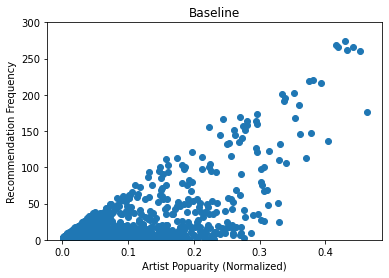

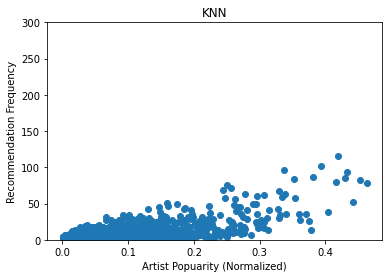

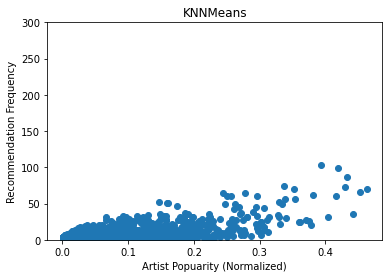

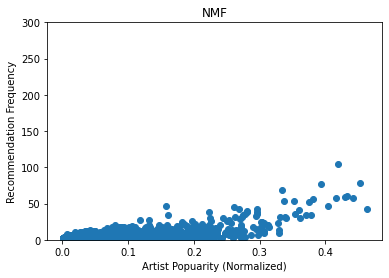

In [46]:
#Create graphs of  the correlation of artist popularity and recommendation frequency
alg_names = ['Baseline', 'KNN', 'KNNMeans', 'NMF']

for i in range(len(alg_names)):
    plot.figure()
    plot.plot(normalized_artist_dist, alg_recommendations[i], 'o')
    plot.xlabel("Artist Popuarity (Normalized)")
    plot.ylabel("Recommendation Frequency")
    plot.title(alg_names[i])
    plot.ylim([0,300])
    plot.show()
    

In [61]:
#Computes change in GAP for each RecSys alg
delta_gap_low_list = []
delta_gap_medium_list = []
delta_gap_high_list = []
for i in range(len(low_gap_r_list)):
    delta_gap_low = ((low_gap_r_list[i] - low_gap_p) / low_gap_p)
    delta_gap_medium = ((medium_gap_r_list[i] - medium_gap_p) / medium_gap_p)
    delta_gap_high = ((high_gap_r_list[i] - high_gap_p) / high_gap_p)
    
    delta_gap_low_list.append(delta_gap_low)
    delta_gap_medium_list.append(delta_gap_medium)
    delta_gap_high_list.append(delta_gap_high)


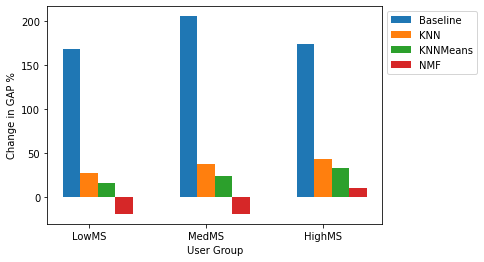

In [57]:
# Bar graph for comparing Delta GAP for each algorithm
x_labels = ["LowMS", "MedMS", "HighMS"]
width = 0.15

bar1 = [delta_gap_low_list[0] * 100, delta_gap_medium_list[0] * 100, delta_gap_high_list[0]* 100]
bar2 = [delta_gap_low_list[1] * 100, delta_gap_medium_list[1] * 100, delta_gap_high_list[1] * 100]
bar3 = [delta_gap_low_list[2] * 100, delta_gap_medium_list[2] * 100, delta_gap_high_list[2] * 100]
bar4 = [delta_gap_low_list[3] * 100, delta_gap_medium_list[3] * 100, delta_gap_high_list[3] * 100]

x1 = np.arange(3) #low/md/and high
x2 = [i+width for i in x1]
x3 = [i+width for i in x2]
x4 = [i+width for i in x3]
plot.bar(x1, bar1, width = 0.15, label ="Baseline")
plot.bar(x2, bar2, width = 0.15, label ="KNN")
plot.bar(x3, bar3, width = 0.15, label ="KNNMeans")
plot.bar(x4, bar4, width = 0.15, label ="NMF")

plot.xlabel("User Group")
plot.ylabel("Change in GAP %")
plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plot.xticks(x1 + width, x_labels)
plot.show()

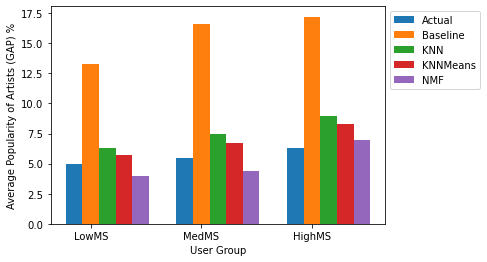

In [56]:
# bar graph comparing the GAP of each alg + the actual GAP on the dataset
x_labels = ["LowMS", "MedMS", "HighMS"]
bar1 = [low_gap_p * 100, medium_gap_p * 100, high_gap_p * 100]
bar2 = [low_gap_r_list[0] * 100, medium_gap_r_list[0] * 100, high_gap_r_list[0] * 100]
bar3 = [low_gap_r_list[1] * 100, medium_gap_r_list[1] * 100, high_gap_r_list[1] * 100]
bar4 = [low_gap_r_list[2] * 100, medium_gap_r_list[2] * 100, high_gap_r_list[2] * 100]
bar5 = [low_gap_r_list[3] * 100, medium_gap_r_list[3] * 100, high_gap_r_list[3] * 100]

x1 = np.arange(3) #low/md/and high
x2 = [i+width for i in x1]
x3 = [i+width for i in x2]
x4 = [i+width for i in x3]
x5 = [i+width for i in x4]
plot.bar(x1, bar1, width = 0.15, label ="Actual")
plot.bar(x2, bar2, width = 0.15, label ="Baseline")
plot.bar(x3, bar3, width = 0.15, label ="KNN")
plot.bar(x4, bar4, width = 0.15, label ="KNNMeans")
plot.bar(x5, bar5, width = 0.15, label ="NMF")

plot.xlabel("User Group")
plot.ylabel("Average Popularity of Artists (GAP) %")
plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plot.xticks(x1 + width, x_labels)
plot.show()